# <a id='toc1_'></a>[2) Cars4You ML Project Price Prediction](#toc0_)
---
**Group 2:**

- Luis Mendes 20221949
- Margarida Mourives 20221809
- Simon Sazonov 20221689 
- Veronica Mendes 20221945

**Group Member Contribution:**
- Luis Mendes:
- Margarida Mourives:
- Simon Sazonov:
- Veronica Mendes:

---



**Table of contents**<a id='toc0_'></a> 
- [Imports](#toc2_)    
- [Data Integration](#toc3_)    
- [Modeling](#toc4_)    
    - [Benchmarking](#toc4_1_1_)    
    - [Random Forest](#toc4_1_2_)    
    - [Final Model](#toc4_1_3_)    
- [Deployment](#toc5_)    
    - [Pipeline Test Set](#toc5_1_1_)    
    - [Prediction](#toc5_1_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[Imports](#toc0_)

In [9]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Grid Search
from sklearn.model_selection import ParameterGrid
from itertools import product
import time
# Progress
from tqdm import tqdm
# Spliting
from sklearn.model_selection import KFold
# Scaling
from sklearn.preprocessing import RobustScaler
# Imputation
from sklearn.impute import KNNImputer
# Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
# Evaluation Metrics
from sklearn.metrics import mean_absolute_error
# CV Score and Graphing
from utils import (avg_scores, 
                   graph_actual_vs_predicted, 
                   model_performance, 
                   grid_score, 
                   print_cv_results)

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

sns.set_context("notebook")
sns.set_style("ticks")

# <a id='toc3_'></a>[Data Integration](#toc0_)

We will import the saved data created at the preprocessing step and delete the brand column, since this modeling phase is intended to create one general model for all brands.

In [2]:
# read data

# for CV
X_CV, y_CV = pd.read_pickle('../project_data/X_Ylog_ModelOptimization.pkl')
X_CV.drop(columns=['Brand'], inplace=True)

# full
X_full, y_full, scaler_full, inputer_full = pd.read_pickle('../project_data/X_Ylog_Scale_Impute_ModelFull.pkl')
X_full.drop(columns=['Brand'], inplace=True)

# for HO
X_train_HO, X_val_HO, y_train_HO, y_val_HO, scaler_HO, inputer_HO = pd.read_pickle('../project_data/Train_Val_Yslog_Scalar_Imputer_ModelHO.pkl')
X_train_HO.drop(columns=['Brand'], inplace=True)
X_val_HO.drop(columns=['Brand'], inplace=True)

# <a id='toc4_'></a>[Modeling](#toc0_)

Now we move on to the modeling phase. Based on the dataset, selected features, and previous analysis, we will first establish a benchmark model using Linear Regression. We will evaluate its MAE on both the training and validation sets using CV. After that, we will build additional models and compare their performance to the benchmark, assessing overfitting and the MAE score on the validation set to determine if they provide any improvement.

At the end of the modeling phase, we will identify the best overall model found and compare its performance to this initial benchmark, as well as comparing all candidate models to one another.

To find the best hyperparameters for the models we are going to test, we will use Grid Search  on the Hold-Out (HO) training data. We opted for this approach because we have almost 15,000 rows available for validation, which is a significant number and provides a robust basis for evaluation. To define the range of parameters to test within the Grid Search, we will first analyze arbitrary values that cause the model to clearly overfit and underfit. We will combine this empirical analysis with 'best practice rules' to establish a robust range. We will then select the parameters that fall in the middle of this range for the final, systematic search.

Subsequently, we will take the best model found and perform the Mean Absolute Error (MAE) evaluation using Cross-Validation (CV) to obtain a more robust final score. We opted for this approach because we want to prioritize testing more models rather than obtaining a more robust solution during the initial Grid Search phase. Since CV takes significantly more time, this approach serves as an efficient time-saver.

Let's start by defining some general parameters, such as the scores for the training and validation sets and Cross-Validation (CV).

In [4]:
dic_train_MAE = {}
dic_val_MAE = {}

method_CV = KFold(n_splits= 6, random_state = 22, shuffle= True)

### <a id='toc4_1_1_'></a>[Benchmarking (Linear Regression)](#toc0_)

We will fit a Linear Regression model and use it as a benchmark. We will evaluate its performance on both the training and validation sets.

In [4]:
avg_scores(X = X_CV,
            y = y_CV,
            CV = method_CV,
            imputer = KNNImputer(n_neighbors=10, weights='uniform'),
            scalar = RobustScaler(),
            model = LinearRegression(),
            score_train_dic = dic_train_MAE,
            score_val_dic = dic_val_MAE,
            dic_key = 'LR-BeanchMark',
            log_transform= True)

6it [06:25, 64.33s/it]


In [ ]:
print_cv_results('LR-BeanchMark', dic_train_MAE, dic_val_MAE)

The benchmark model achieved a MAE of £3034 on the training set and £3034 on the validation set, showing no signs of overfitting, as the validation score is almost the same as the training score. The standard deviation of the train MAE is £11.52 and for validation, it is £50.04.

Now, we are going to see the graphical difference between the actual and predicted values for the training and testing sets to analyze the model's results.

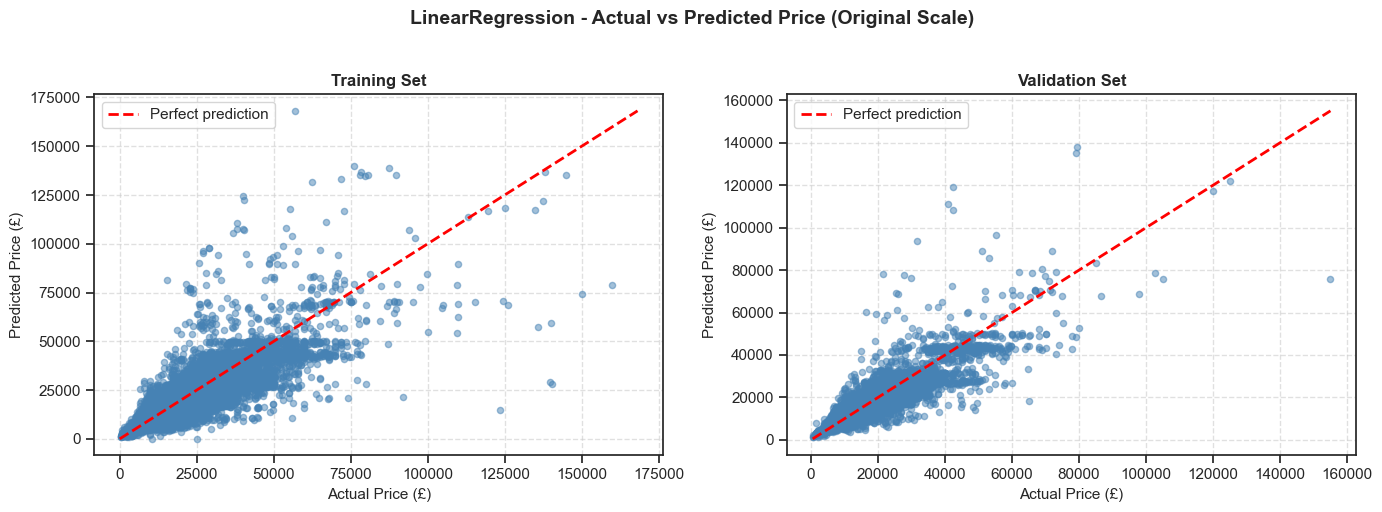

In [4]:
LR_model = LinearRegression()

graph_actual_vs_predicted(LR_model, X_train_HO, y_train_HO, X_val_HO, y_val_HO)

We also see that the model's prediction error starts to increase as the price increases. We will now investigate if other types of models manage to solve this problem.

### KNN

We will test how the K-Nearest Neighbors (KNN) Regressor performs.

Now, let's analyze first on which value k the model underfits.

In [4]:
KNN_model_UF = KNeighborsRegressor(n_neighbors=500, weights='uniform')

model_performance(KNN_model_UF, X_train_HO, y_train_HO, X_val_HO, y_val_HO)

Train MAE: 2834.1396517320013
Validation MAE: 2834.8123333064377


In [13]:
KNN_model_UF = KNeighborsRegressor(n_neighbors=100, weights='uniform')

model_performance(KNN_model_UF, X_train_HO, y_train_HO, X_val_HO, y_val_HO)

Train MAE: 2554.6613049991065
Validation MAE: 2580.773769513367


In [14]:
KNN_model_UF = KNeighborsRegressor(n_neighbors=50, weights='uniform')

model_performance(KNN_model_UF, X_train_HO, y_train_HO, X_val_HO, y_val_HO)

Train MAE: 2439.199422453673
Validation MAE: 2496.183645947641


After testing with k equal to 500, 100, and 50, we see that the model does not underfit within these ranges. However, there is a clear trend that the higher the value of k, the worse the score gets. For that reason, we will set the higher ceiling of our Grid Search range to k = 100.

Now, let's see on which value of k the model overfits.

In [7]:
KNN_model_OF = KNeighborsRegressor(n_neighbors=7, weights='uniform')

model_performance(KNN_model_OF, X_train_HO, y_train_HO, X_val_HO, y_val_HO)

Train MAE: 1971.316248307592
Validation MAE: 2292.5692980160975


Starting at k=7, the model begins to exhibit overfitting (training error is significantly lower than validation error). Therefore, the lower ceiling for our Grid Search range will be k=7.

Now, let's analyze the performance using distance-weighted contributions (where closer points have a greater influence on the prediction).

In [6]:
KNN_model_UF = KNeighborsRegressor(n_neighbors=1000, weights='distance')

model_performance(KNN_model_UF, X_train_HO, y_train_HO, X_val_HO, y_val_HO)

Train MAE: 63.79778140295198
Validation MAE: 2632.3474760301433


In [8]:
KNN_model_OF = KNeighborsRegressor(n_neighbors=2, weights='distance')

model_performance(KNN_model_OF, X_train_HO, y_train_HO, X_val_HO, y_val_HO)

Train MAE: 66.79702566684055
Validation MAE: 2348.9061914504346


We see that for a large range of k values, the model exhibits significant overfitting. For that reason, we are not going to proceed with testing the distance-weighted method.

Now, let's find the best parameters using Grid Search , based on the lower and upper ceilings that we found.

In [9]:
# Define the parameters to test
param_grid = {'n_neighbors': list(range(7, 101))}

grid = ParameterGrid(param_grid)

# Create dictionaries to save the scores
dic_train_score_knn = {}
dic_val_score_knn = {}

In [ ]:
for params in tqdm(grid):
    grid_score(x_train = X_train_HO,
               y_train = y_train_HO,
               x_val = X_val_HO,
               y_val = y_val_HO,
               model = KNeighborsRegressor(n_neighbors=params['n_neighbors'], weights='uniform', n_jobs=-1),
               score_train_dic = dic_train_score_knn,
               score_val_dic = dic_val_score_knn,
               dic_key = ('KNN', params['n_neighbors']),
               log_transform= True)

100%|██████████| 94/94 [07:03<00:00,  4.51s/it]


Now, let's visualize the results of the training and validation MAE scores as a function of k (the number of neighbors).

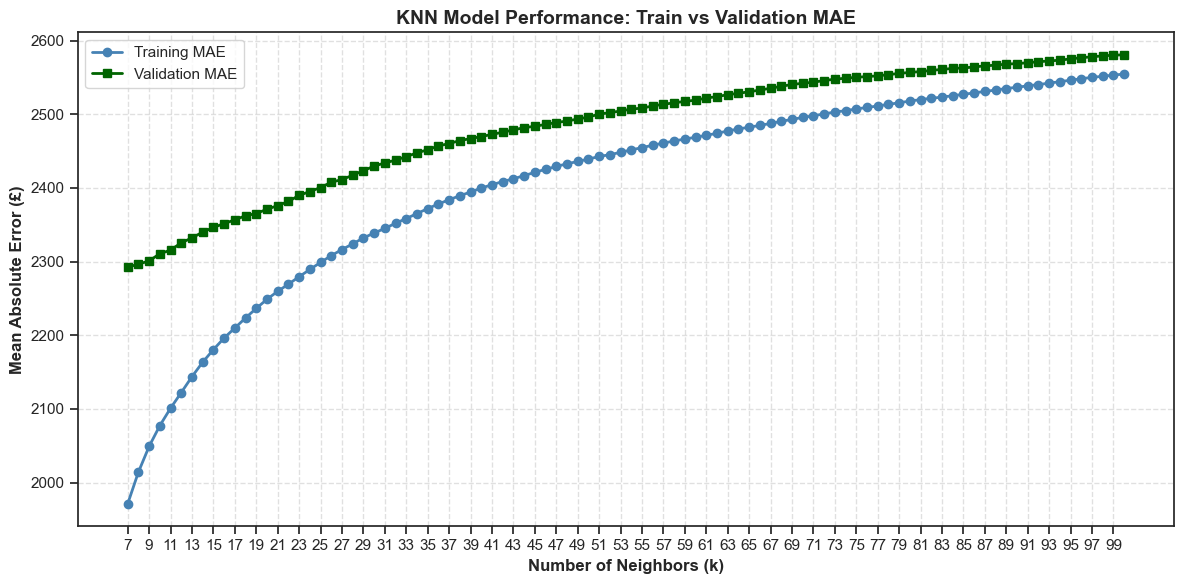

In [13]:
# Extract keys and values from dictionaries
neighbors = sorted([key[1] for key in dic_train_score_knn.keys()])
train_mae = [dic_train_score_knn[('KNN', n)] for n in neighbors]
val_mae = [dic_val_score_knn[('KNN', n)] for n in neighbors]

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(neighbors, train_mae, marker='o', linewidth=2, label='Training MAE', color='steelblue')
plt.plot(neighbors, val_mae, marker='s', linewidth=2, label='Validation MAE', color='darkgreen')

plt.xlabel('Number of Neighbors (k)', fontsize=12, fontweight='bold')
plt.ylabel('Mean Absolute Error (£)', fontsize=12, fontweight='bold')
plt.title('KNN Model Performance: Train vs Validation MAE', fontsize=14, fontweight='bold')
plt.xticks(range(7, 101, 2))
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=11, loc='best')
plt.tight_layout()
plt.show()

We see that as k increases, the difference between the training and validation MAE decreases (indicating less overfitting), but the MAE result is worse (higher). For that reason, we are going to plot the overfitting graph to analyze which model to use.

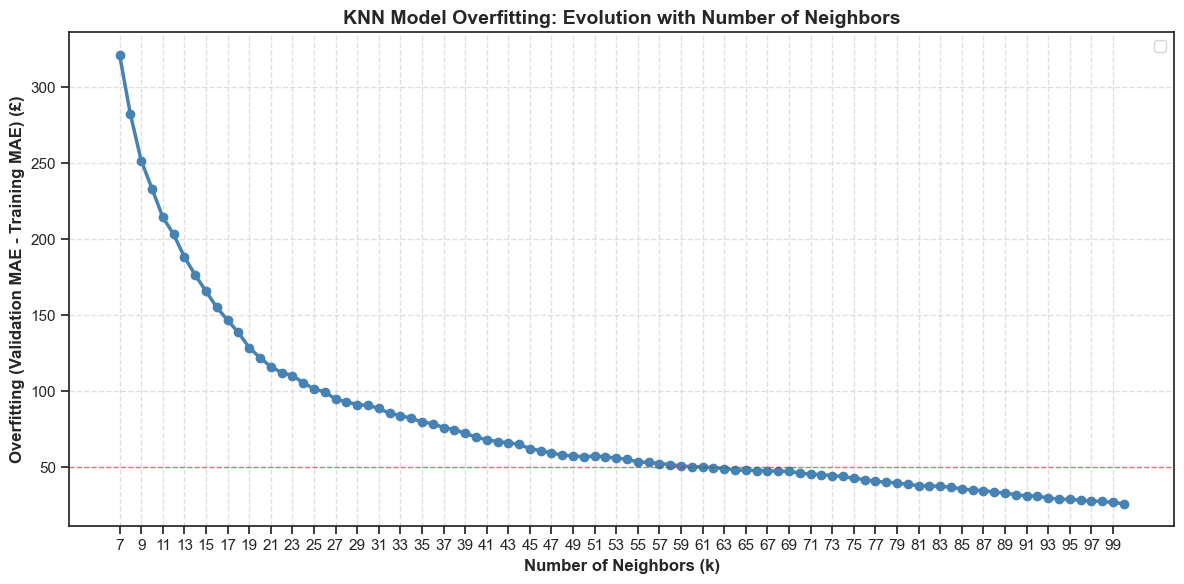

In [28]:
# Calculate overfitting (difference between validation and training MAE)
overfitting = np.subtract(val_mae, train_mae)

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(neighbors, overfitting, marker='o', linewidth=2.5, markersize=6, color='steelblue')

plt.xlabel('Number of Neighbors (k)', fontsize=12, fontweight='bold')
plt.ylabel('Overfitting (Validation MAE - Training MAE) (£)', fontsize=12, fontweight='bold')
plt.title('KNN Model Overfitting: Evolution with Number of Neighbors', fontsize=14, fontweight='bold')
plt.axhline(y=50, color='Red', linestyle='--', linewidth=1, alpha=0.5)
plt.xticks(range(7, 101, 2))
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=11, loc='best')
plt.tight_layout()
plt.show()

After seeing the overfitting evolution, we see that the overfitting gap (difference between train and validation MAE) reaches a plateau around £50. For that reason, we are going to choose the first k when the model reaches the plateau, which should be k = 59.

Now, let's calculate a robust score for this K-Nearest Neighbors (KNN) model, using Cross-Validation (CV).

In [ ]:
avg_scores(X = X_CV,
            y = y_CV,
            CV = method_CV,
            imputer = KNNImputer(n_neighbors=10, weights='uniform'),
            scalar = RobustScaler(),
            model = KNeighborsRegressor(n_neighbors=59, weights='uniform', n_jobs=-1),
            score_train_dic = dic_train_MAE,
            score_val_dic = dic_val_MAE,
            dic_key = 'KNN',
            log_transform= True)

6it [06:52, 68.83s/it]


In [ ]:
print_cv_results('KNN', dic_train_MAE, dic_val_MAE)

CV Results - KNN-k59
Train MAE: 2458.21, Train std: 5.96
Validation MAE: 2503.57, Validatin std: 31.45


Let's now analyze the actual vs. predicted values of that model.

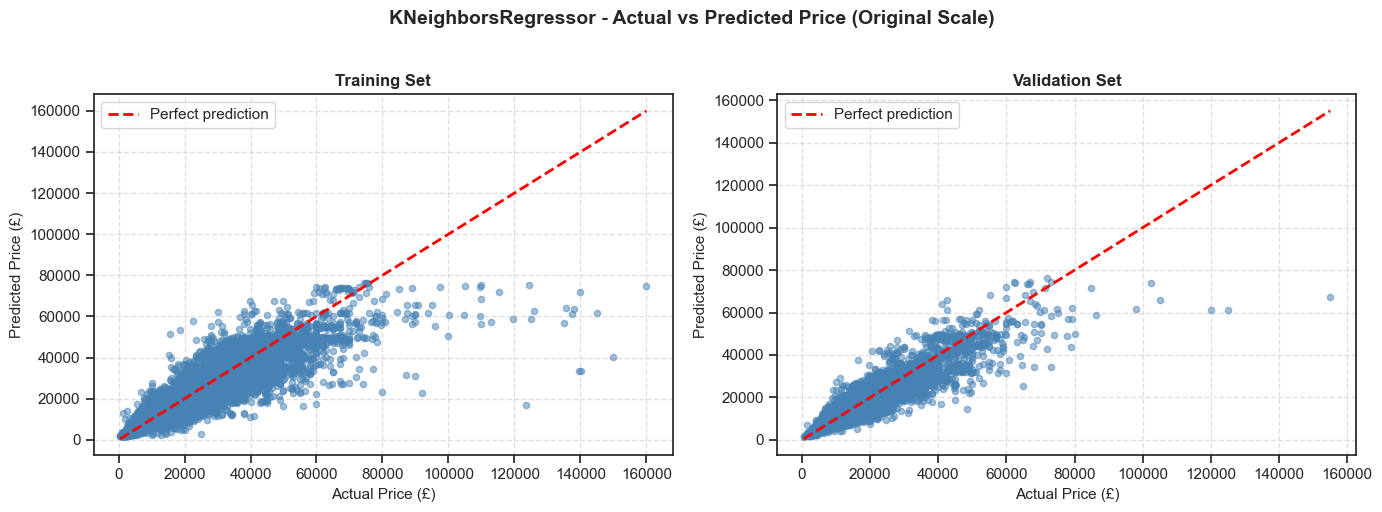

In [23]:
KNN_model = KNeighborsRegressor(n_neighbors=59, weights='uniform')

graph_actual_vs_predicted(KNN_model, X_train_HO, y_train_HO, X_val_HO, y_val_HO)

### Decision Tree (DT)

We will test how the K-Nearest Neighbors (KNN) Regressor performs.

Now, let's analyze first on which value k the model underfits.

In [ ]:
KNN_model_UF = KNeighborsRegressor(n_neighbors=500, weights='uniform')

model_performance(KNN_model_UF, X_train_HO, y_train_HO, X_val_HO, y_val_HO)

Train MAE: 2834.1396517320013
Validation MAE: 2834.8123333064377


In [ ]:
KNN_model_UF = KNeighborsRegressor(n_neighbors=100, weights='uniform')

model_performance(KNN_model_UF, X_train_HO, y_train_HO, X_val_HO, y_val_HO)

Train MAE: 2554.6613049991065
Validation MAE: 2580.773769513367


In [ ]:
KNN_model_UF = KNeighborsRegressor(n_neighbors=50, weights='uniform')

model_performance(KNN_model_UF, X_train_HO, y_train_HO, X_val_HO, y_val_HO)

Train MAE: 2439.199422453673
Validation MAE: 2496.183645947641


After testing with k equal to 500, 100, and 50, we see that the model does not underfit within these ranges. However, there is a clear trend that the higher the value of k, the worse the score gets. For that reason, we will set the higher ceiling of our Grid Search range to k = 100.

Now, let's see on which value of k the model overfits.

In [ ]:
KNN_model_OF = KNeighborsRegressor(n_neighbors=7, weights='uniform')

model_performance(KNN_model_OF, X_train_HO, y_train_HO, X_val_HO, y_val_HO)

Train MAE: 1971.316248307592
Validation MAE: 2292.5692980160975


Starting at k=7, the model begins to exhibit overfitting (training error is significantly lower than validation error). Therefore, the lower ceiling for our Grid Search range will be k=7.

Now, let's find the best parameters using Grid Search , based on the lower and upper ceilings that we found.

In [ ]:
# Define the parameters to test
param_grid = {'n_neighbors': list(range(7, 101))}

grid = ParameterGrid(param_grid)

# Create dictionaries to save the scores
dic_train_score_knn = {}
dic_val_score_knn = {}

In [ ]:
for params in tqdm(grid):
    grid_score(x_train = X_train_HO,
               y_train = y_train_HO,
               x_val = X_val_HO,
               y_val = y_val_HO,
               model = KNeighborsRegressor(n_neighbors=params['n_neighbors'], weights='uniform'),
               score_train_dic = dic_train_score_knn,
               score_val_dic = dic_val_score_knn,
               dic_key = ('KNN', params['n_neighbors']),
               log_transform= True)

100%|██████████| 94/94 [07:03<00:00,  4.51s/it]


Now, let's visualize the results of the training and validation MAE scores as a function of k (the number of neighbors).

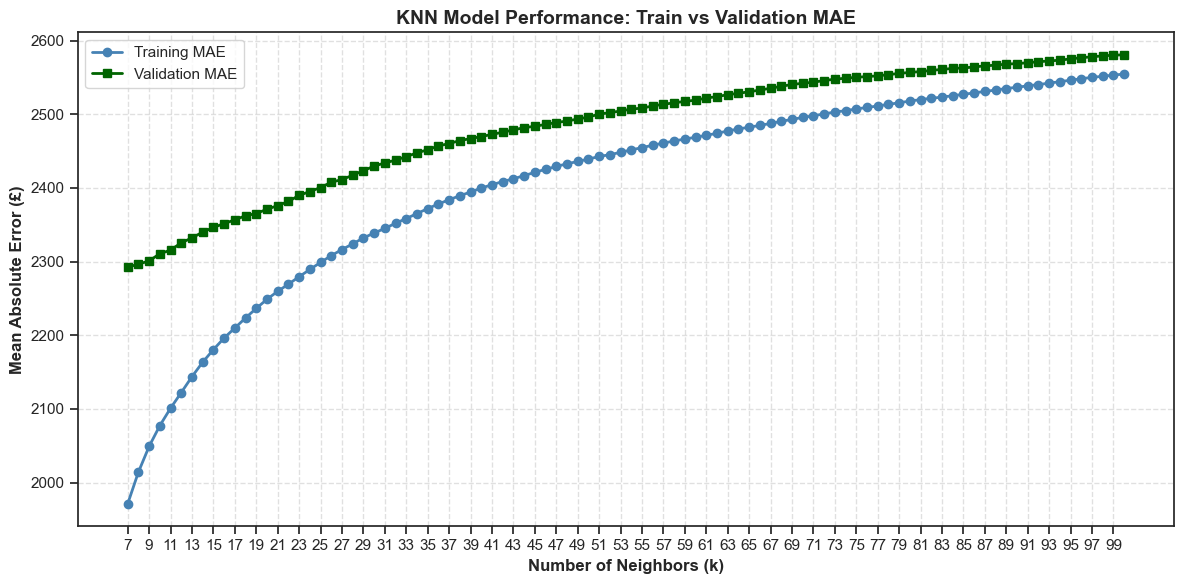

In [ ]:
# Extract keys and values from dictionaries
neighbors = sorted([key[1] for key in dic_train_score_knn.keys()])
train_mae = [dic_train_score_knn[('KNN', n)] for n in neighbors]
val_mae = [dic_val_score_knn[('KNN', n)] for n in neighbors]

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(neighbors, train_mae, marker='o', linewidth=2, label='Training MAE', color='steelblue')
plt.plot(neighbors, val_mae, marker='s', linewidth=2, label='Validation MAE', color='darkgreen')

plt.xlabel('Number of Neighbors (k)', fontsize=12, fontweight='bold')
plt.ylabel('Mean Absolute Error (£)', fontsize=12, fontweight='bold')
plt.title('KNN Model Performance: Train vs Validation MAE', fontsize=14, fontweight='bold')
plt.xticks(range(7, 101, 2))
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=11, loc='best')
plt.tight_layout()
plt.show()

We see that as k increases, the difference between the training and validation MAE decreases (indicating less overfitting), but the MAE result is worse (higher). For that reason, we are going to plot the overfitting graph to analyze which model to use.

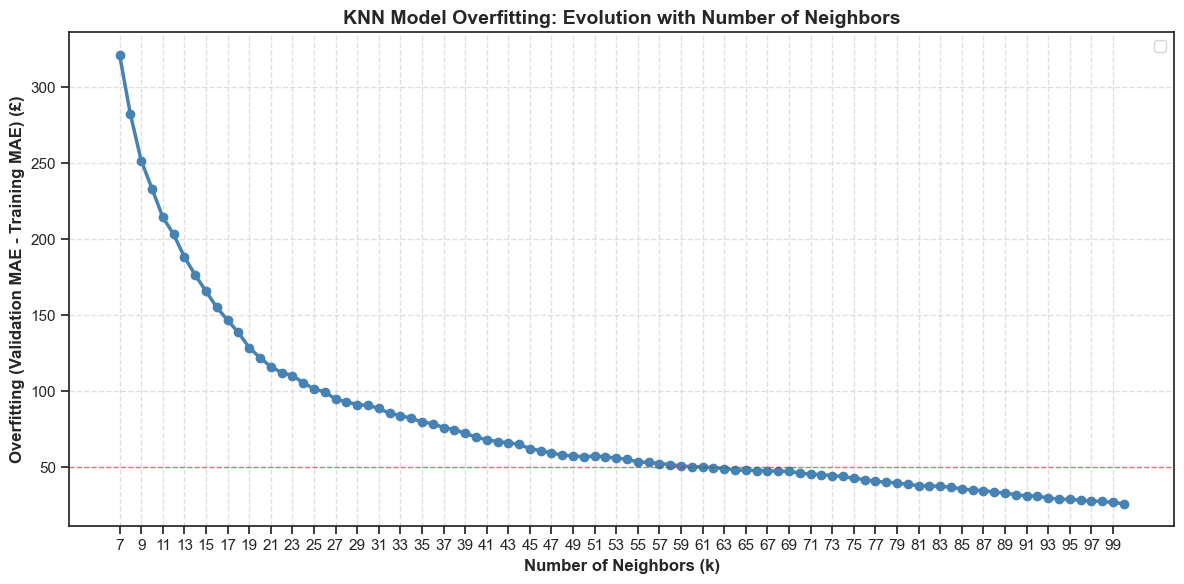

In [ ]:
# Calculate overfitting (difference between validation and training MAE)
overfitting = np.subtract(val_mae, train_mae)

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(neighbors, overfitting, marker='o', linewidth=2.5, markersize=6, color='steelblue')

plt.xlabel('Number of Neighbors (k)', fontsize=12, fontweight='bold')
plt.ylabel('Overfitting (Validation MAE - Training MAE) (£)', fontsize=12, fontweight='bold')
plt.title('KNN Model Overfitting: Evolution with Number of Neighbors', fontsize=14, fontweight='bold')
plt.axhline(y=50, color='Red', linestyle='--', linewidth=1, alpha=0.5)
plt.xticks(range(7, 101, 2))
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=11, loc='best')
plt.tight_layout()
plt.show()

After seeing the overfitting evolution, we see that the overfitting gap (difference between train and validation MAE) reaches a plateau around £50. For that reason, we are going to choose the first k when the model reaches the plateau, which should be k = 59.

Now, let's calculate a robust score for this K-Nearest Neighbors (KNN) model, using Cross-Validation (CV).

In [ ]:
avg_scores(X = X_CV,
            y = y_CV,
            CV = method_CV,
            imputer = KNNImputer(n_neighbors=10, weights='uniform'),
            scalar = RobustScaler(),
            model = KNeighborsRegressor(n_neighbors=59, weights='uniform'),
            score_train_dic = dic_train_MAE,
            score_val_dic = dic_val_MAE,
            dic_key = 'KNN',
            log_transform= True)

6it [06:52, 68.83s/it]


In [ ]:
print_cv_results('KNN', dic_train_MAE, dic_val_MAE)

CV Results - KNN-k59
Train MAE: 2458.21, Train std: 5.96
Validation MAE: 2503.57, Validatin std: 31.45


Let's now analyze the actual vs. predicted values of that model.

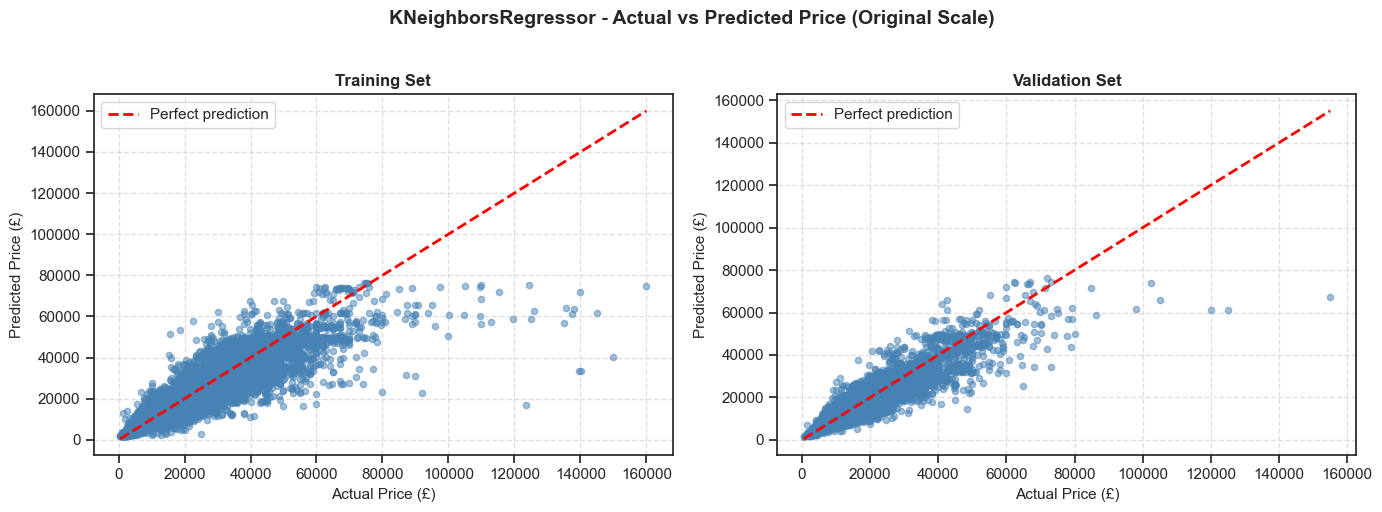

In [ ]:
KNN_model = KNeighborsRegressor(n_neighbors=59, weights='uniform')

graph_actual_vs_predicted(KNN_model, X_train_HO, y_train_HO, X_val_HO, y_val_HO)

### <a id='toc4_1_2_'></a>[Random Forest](#toc0_)

In [271]:
RF_model = RandomForestRegressor(random_state=0,
                                criterion='absolute_error',
                                max_features='sqrt',
                                max_depth=10,
                                min_samples_split=10,
                                min_samples_leaf = 5,
                                n_jobs=-1)

RF_model.fit(X_train_imputed, y_train)

print('Train:', mean_absolute_error(y_train, RF_model.predict(X_train_imputed)))
print('Validation:', mean_absolute_error(y_val, RF_model.predict(X_val_imputed)))

Train: 2301.870071670686
Validation: 2361.1593892074197


The Random Forest model achieved a MAE of £2,361 on the validation set, showing a slight overfitting of approximately £61.

### <a id='toc4_1_3_'></a>[Final Model](#toc0_)

The best model was the Random Forest, as it achieved a lower MAE on the validation set (£2,361 vs £3,440 for Linear Regression) while exhibiting only a small amount of overfitting.

Since this model does not require a validation set to control the training process, we will train it on the entire dataset (training + validation) before making predictions on the test set.

In [ ]:
# define imputer, scalar, train on hold out or hole dataset

In [274]:
best_model = RandomForestRegressor(random_state=0,
                                criterion='absolute_error',
                                max_features='sqrt',
                                max_depth=10,
                                min_samples_split=10,
                                min_samples_leaf = 5,
                                n_jobs=-1)
best_model.fit(X_full,y_full)

,n_estimators,100
,criterion,'absolute_error'
,max_depth,10
,min_samples_split,10
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


#### Parameter Grid for RandomForestRegressor

In [7]:
param_grid_rf = {
    "n_estimators": [200, 400, 800],        
    "max_depth": [None, 10, 20, 30],          
    "min_samples_split": [0.1, 0.2, 0.4],    
    "max_features": [0.4, 0.6, 0.8, 1.0],          
    "bootstrap": [True, False],
    "criterion": ['squared_error', 'absolute_error']
}

In [ ]:
# Create all combinations of hyperparameters
keys, values = zip(*param_grid_rf.items())
param_combos_rf = [dict(zip(keys, v)) for v in product(*values)]

results_rf = []

print("\n=== RANDOM FOREST  ===")

for params in param_combos_rf:

    start = time.time()

    # Train model
    model = RandomForestRegressor(
        n_jobs=-1,
        random_state=1,
        **params
    )
    model.fit(X_train_HO, y_train_HO)

    # Predictions
    train_pred = model.predict(X_train_HO)
    val_pred = model.predict(X_val_HO)

    # Compute MAE
    train_mae = mean_absolute_error(y_train_HO, train_pred)
    val_mae = mean_absolute_error(y_val_HO, val_pred)

    # Overfitting score
    overfit_score = train_mae - val_mae

    # Store result
    results_rf.append({
        **params,
        "train_mae": train_mae,
        "val_mae": val_mae,
        "overfit_score": overfit_score,
        "fit_time": time.time() - start
    })

    # Log progress
    print(f"{params} -> Val MAE: {val_mae:.4f} | Overfit: {overfit_score:.4f}")

# Convert to DataFrame
results_rf = pd.DataFrame(results_rf)


=== RANDOM FOREST  ===
{'n_estimators': 200, 'max_depth': None, 'min_samples_split': 0.1, 'max_features': 0.4, 'bootstrap': True, 'criterion': 'squared_error'} -> Val MAE: 0.2056 | Overfit: 0.0004


##### Find the best model

In [ ]:
rf_best = results_rf.sort_values("val_mae").iloc[0]
bg_best = results_bg.sort_values("val_mae").iloc[0]

print("BEST RANDOM FOREST:")
display(rf_best)

print("BEST BAGGING KNN:")
display(bg_best)

##### Graphics to visualize Bihavior

Train vs Validation MAE (Random Forest)

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(results_rf["train_mae"], results_rf["val_mae"], alpha=0.6)
plt.xlabel("Train MAE")
plt.ylabel("Validation MAE")
plt.title("Random Forest — Train vs Validation MAE")
plt.plot([results_rf["train_mae"].min(), results_rf["train_mae"].max()],
         [results_rf["train_mae"].min(), results_rf["train_mae"].max()],
         linestyle="--")  # reference diagonal
plt.show()


Overfitting Score Distribution

In [ ]:
plt.figure(figsize=(10,6))
plt.hist(results_rf["overfit_score"], bins=30)
plt.title("Random Forest — Overfitting Score Distribution")
plt.xlabel("Overfit Score (train MAE - val MAE)")
plt.ylabel("Count")
plt.show()


# <a id='toc5_'></a>[Deployment](#toc0_)

Let's prepare the test data for predictions. First, we will perform the preprocessing steps one by one, and then create a function that applies all transformations automatically whenever a test dataframe is provided.

### <a id='toc5_1_1_'></a>[Pipeline Test Set](#toc0_)

In [ ]:
def preprocess_and_predict(
    test_df,
    dict_brand_mapping,
    dict_transmission_mapping,
    dict_fuelType_mapping,
    mode_to_fill_transmission,
    mode_to_fill_fueltype,
    train_dummy_columns,
    numerical_cols,
    scaler,
    model,
    imputer,
    filename
):
    # Copy test data
    df_test = test_df.copy()
    df_test.set_index('carID', inplace=True)
    
    # Drop irrelevant columns
    df_test.drop(['paintQuality%', 'hasDamage'], inplace=True, axis=1)
    
    # Correct numeric columns
    df_test['year'] = df_test['year'].round().astype('Int64')
    df_test['mileage'] = pd.to_numeric(df_test['mileage'], errors='coerce').abs()
    df_test['tax'] = pd.to_numeric(df_test['tax'], errors='coerce').abs()
    df_test['mpg'] = pd.to_numeric(df_test['mpg'], errors='coerce').abs()
    df_test['engineSize'] = pd.to_numeric(df_test['engineSize'], errors='coerce').abs()
    df_test.loc[df_test['engineSize'] < 0.9, 'engineSize'] = 0.9
    df_test['previousOwners'] = pd.to_numeric(df_test['previousOwners'], errors='coerce').abs()
    df_test['previousOwners'] = df_test['previousOwners'].round().astype('Int64')
    
    # Clean strings
    df_test = df_test.applymap(lambda x: x.replace(" ", "").lower() if isinstance(x, str) else x)
    
    # Map categorical values
    for key, values in dict_brand_mapping.items():
        df_test.loc[df_test['Brand'].isin(values), 'Brand'] = key
    
    for key, values in dict_transmission_mapping.items():
        df_test.loc[df_test['transmission'].isin(values), 'transmission'] = key if key != 'NAN' else np.nan
    
    for key, values in dict_fuelType_mapping.items():
        df_test.loc[df_test['fuelType'].isin(values), 'fuelType'] = key
    
    # Fill missing categorical values
    df_test['transmission'].fillna(mode_to_fill_transmission, inplace=True)
    df_test['fuelType'].fillna(mode_to_fill_fueltype, inplace=True)
    
    # years old
    
    # Simplify fuelType
    df_test.loc[df_test['fuelType'].isin(['electric', 'hybrid']), 'fuelType'] = 'other'
    
    # Encode categorical variables as dummies
    df_test = pd.get_dummies(df_test, columns=['transmission', 'fuelType'], drop_first=True)
    
    # Add missing dummy columns
    missing_cols = set(train_dummy_columns) - set(df_test.columns)
    for col in missing_cols:
        df_test[col] = 0
    
    # Ensure column order matches training
    df_test = df_test[train_dummy_columns]
    
    # Scale numerical columns
    df_test_num_scaled = scaler.transform(df_test[numerical_cols])
    df_test_num_scaled = pd.DataFrame(df_test_num_scaled, columns=numerical_cols, index=df_test.index)
    
    # Combine scaled numeric and dummy variables
    dummy_cols = [col for col in df_test.columns if col not in numerical_cols]
    df_test_scaled = pd.concat([df_test_num_scaled, df_test[dummy_cols]], axis=1)
    
    # Impute missing values
    df_test_imputed = imputer.transform(df_test_scaled)
    df_test_to_predict = pd.DataFrame(df_test_imputed, columns=df_test_scaled.columns, index=df_test.index)
    
    # Generate predictions
    predictions = model.predict(df_test_to_predict)
    
    # Create predictions DataFrame
    df_predictions = pd.DataFrame({'price': predictions}, index=df_test_to_predict.index)
    
    # Save predictions
    df_predictions.to_csv(f"predictions/{filename}.csv")
    
    return df_predictions

### <a id='toc5_1_2_'></a>[Prediction](#toc0_)

In [ ]:
dict_brand_mapping, dict_transmission_mapping, mode_to_fill_transmission, columns_names_train = pd.read_pickle('../project_data/DicBrand_DicTrans_ModeTrans_ColNames_PrePro.pkl')

In [282]:
df_test = pd.read_csv('../project_data/test.csv')

df_test_predicted = preprocess_and_predict(
    test_df = df_test,
    dict_brand_mapping = dict_brand_mapping,
    dict_transmission_mapping = dict_transmission_mapping,
    dict_fuelType_mapping = dict_fuelType_mapping,
    mode_to_fill_transmission = mode_to_fill_transmission,
    mode_to_fill_fueltype = mode_to_fill_fueltype,
    train_dummy_columns = train_dummy_columns,
    numerical_cols = numerical_cols,
    scaler = scaler,
    model = best_model,
    imputer = inputer,
    filename= 'Group02_Version01'
)

In [283]:
df_test_predicted.head()

,price
carID,
89856,18797.680
106581,22750.630
80886,12483.970
100174,14512.575
81376,26958.055
